### Import Packages 

In [1]:
import os
import math
import random
from pprint import pprint

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    FunctionTransformer,
    StandardScaler,
    PowerTransformer,
    MinMaxScaler,
    OneHotEncoder,
)
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tqdm.notebook import tqdm

### Basic Notebook seetings and Package Config

In [2]:
sns.set_theme(style="darkgrid")
pd.set_option("display.max_colwidth", 1000)
random.seed(100)
tqdm.pandas()
set_config(display="diagram")

### Adding SRC directory to sys path 

In [3]:
parent_directory = os.path.abspath(
    "../.."
)  # Should Point to root directory /Project Directory
os.chdir(parent_directory)

print(f"parent directory {parent_directory}")

datset_dir = os.path.join(parent_directory, "data")

if os.path.isdir(datset_dir) is False:
    raise NotADirectoryError(f"Directory {datset_dir} not valid")

parent directory D:\codespace\python\datascience_ml_handson


### Dataset Loading

In [4]:
dataframe = pd.read_csv(os.path.join(datset_dir, "zomato.csv"), encoding="ISO-8859-1")

print(f"dataset {dataframe.shape}")
dataframe.head(3)

dataset (9551, 21)


,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,...,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenue, Poblacion, Makati City","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Makati City",121.027535,14.565443,"French, Japanese, Desserts",...,Botswana Pula(P),Yes,No,No,No,3,4.8,Dark Green,Excellent,314
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Makati City",121.014101,14.553708,Japanese,...,Botswana Pula(P),Yes,No,No,No,3,4.5,Dark Green,Excellent,591
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandaluyong City","Edsa Shangri-La, Ortigas, Mandaluyong City","Edsa Shangri-La, Ortigas, Mandaluyong City, Mandaluyong City",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",...,Botswana Pula(P),Yes,No,No,No,4,4.4,Green,Very Good,270


#### Selecting big Chunk of data

In [5]:
dataframe = dataframe[dataframe["Country Code"] == 1].copy()

print(f"dataset {dataframe.shape}")

dataset (8652, 21)


#### Duplicate Checking & Removing

In [6]:
dataframe.duplicated().sum()
# dataframe.drop_duplicate(keep='first',inplace=True)
# print(dataframe.duplicated().sum())

0

In [7]:
print(dataframe.columns)

Index(['Restaurant ID', 'Restaurant Name', 'Country Code', 'City', 'Address',
       'Locality', 'Locality Verbose', 'Longitude', 'Latitude', 'Cuisines',
       'Average Cost for two', 'Currency', 'Has Table booking',
       'Has Online delivery', 'Is delivering now', 'Switch to order menu',
       'Price range', 'Aggregate rating', 'Rating color', 'Rating text',
       'Votes'],
      dtype='object')


In [8]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8652 entries, 624 to 9275
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Restaurant ID         8652 non-null   int64  
 1   Restaurant Name       8652 non-null   object 
 2   Country Code          8652 non-null   int64  
 3   City                  8652 non-null   object 
 4   Address               8652 non-null   object 
 5   Locality              8652 non-null   object 
 6   Locality Verbose      8652 non-null   object 
 7   Longitude             8652 non-null   float64
 8   Latitude              8652 non-null   float64
 9   Cuisines              8652 non-null   object 
 10  Average Cost for two  8652 non-null   int64  
 11  Currency              8652 non-null   object 
 12  Has Table booking     8652 non-null   object 
 13  Has Online delivery   8652 non-null   object 
 14  Is delivering now     8652 non-null   object 
 15  Switch to order men

### Data Preprocessing

##### Building Column Trnsformer For 'City' Column

In [9]:
class ReduceUnique(BaseEstimator, TransformerMixin):
    def __init__(self, unique_count=3):
        self.unique_count = unique_count
        self.frequent_k_items = []

    def fit(self, X, y=None):
        series_data = pd.Series(X.flatten()).copy()
        self.frequent_k_items = (
            series_data.value_counts().nlargest(self.unique_count).index.tolist()
        )
        print(f"frequent {self.unique_count} items are {self.frequent_k_items}")
        return self

    def transform(self, X, y=None):
        trnsformed = pd.DataFrame(X, columns=["Column_A"])
        trnsformed["Column_A"] = trnsformed["Column_A"].apply(self.map_items)
        return trnsformed

    def map_items(self, item):
        return item if item in self.frequent_k_items else "new_city"


def strip_then_lower_case(data):
    return data.strip().lower()


city_transformers = Pipeline(
    [
        ("imputer", SimpleImputer(missing_values="new_city", strategy="constant")),
        (
            "toLower",
            FunctionTransformer(np.vectorize(strip_then_lower_case), validate=False),
        ),
        ("maper", ReduceUnique(unique_count=4)),
        ("encoder", OneHotEncoder(drop="first", max_categories=5)),
    ]
)

city_transformers

Pipeline(steps=[('imputer',
                 SimpleImputer(missing_values='new_city', strategy='constant')),
                ('toLower',
                 FunctionTransformer(func=<numpy.vectorize object at 0x0000027FF66C7880>)),
                ('maper', ReduceUnique(unique_count=4)),
                ('encoder', OneHotEncoder(drop='first', max_categories=5))])

In [10]:
data_pre_processor = ColumnTransformer(
    transformers=[("trf", city_transformers, ["City"])], remainder="drop"
)

pre_processed_data = data_pre_processor.fit_transform(dataframe)

print(f"pre processed data shape {pre_processed_data.shape}")

frequent 4 items are ['new delhi', 'gurgaon', 'noida', 'faridabad']
pre processed data shape (8652, 4)


##### Building Column Trnsformer For 'Latitude' and 'Longitude'

In [11]:
lat_long_transformers = Pipeline(
    [("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)
lat_long_transformers

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())])

In [12]:
data_pre_processor = ColumnTransformer(
    transformers=[
        ("city_trf", city_transformers, ["City"]),
        ("latlong_trf", lat_long_transformers, ["Longitude", "Latitude"]),
    ],
    remainder="drop",
)

pre_processed_data = data_pre_processor.fit_transform(dataframe)

print(f"pre processed data shape {pre_processed_data.shape}")

frequent 4 items are ['new delhi', 'gurgaon', 'noida', 'faridabad']
pre processed data shape (8652, 6)


##### Building Column Trnsformer For 'Average Cost for two'

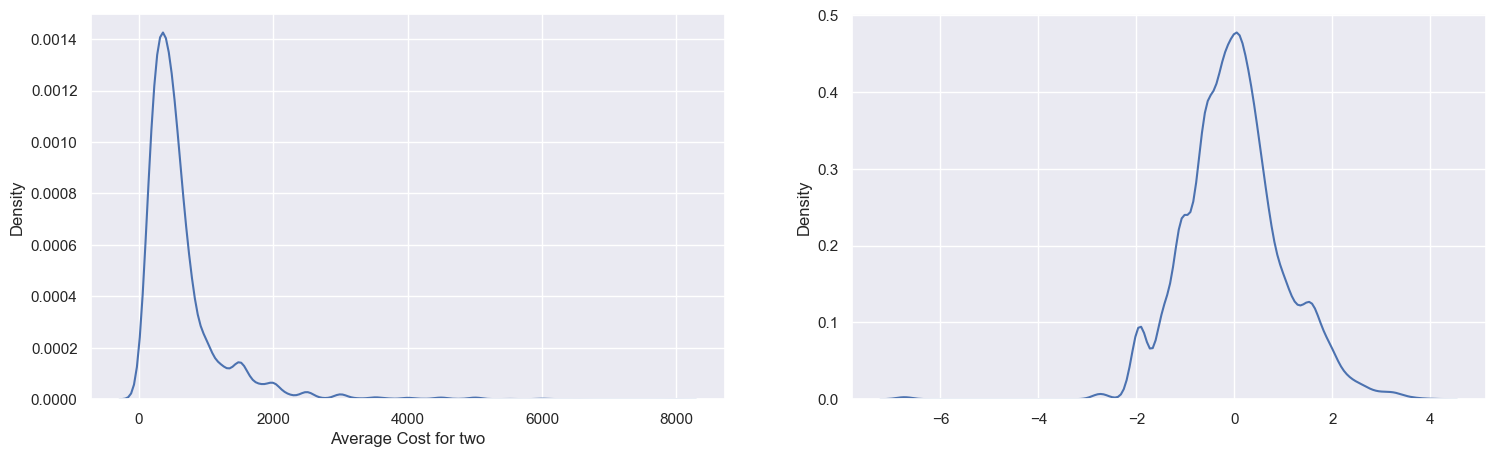

In [13]:
fig, (axs1, axs2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

sns.kdeplot(x="Average Cost for two", data=dataframe, ax=axs1)

pt = PowerTransformer(method="yeo-johnson")

pt_trf = pt.fit_transform(dataframe[["Average Cost for two"]].values)

sns.kdeplot(x=pt_trf.flatten(), ax=axs2)

plt.show()

In [14]:
avg_cost_transformers = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="mean")),
        #("scaler", StandardScaler()),
        # ("toLogtrf", FunctionTransformer(np.vectorize(np.log), validate=False )),
        ("sysmtrf", PowerTransformer(method="yeo-johnson")),
    ]
)
avg_cost_transformers

Pipeline(steps=[('imputer', SimpleImputer()), ('sysmtrf', PowerTransformer())])

In [15]:
data_pre_processor = ColumnTransformer(
    transformers=[
        ("city_trf", city_transformers, ["City"]),
        ("latlong_trf", lat_long_transformers, ["Longitude", "Latitude"]),
        ("avg_cost_transformers", avg_cost_transformers, ["Average Cost for two"]),
    ],
    remainder="drop",
)

pre_processed_data = data_pre_processor.fit_transform(dataframe)

print(f"pre processed data shape {pre_processed_data.shape}")

frequent 4 items are ['new delhi', 'gurgaon', 'noida', 'faridabad']
pre processed data shape (8652, 7)


##### Building Column Trnsformer For 'Has Table booking & Has Online delivery'

In [16]:
def yes_no_2_binary(value):
    return 1 if value == "yes" else 0


yes_no_transformers = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "toLower",
            FunctionTransformer(np.vectorize(strip_then_lower_case), validate=False),
        ),
        (
            "binay_coding",
            FunctionTransformer(np.vectorize(yes_no_2_binary), validate=False),
        ),
    ]
)
yes_no_transformers

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('toLower',
                 FunctionTransformer(func=<numpy.vectorize object at 0x0000027FF68BEFA0>)),
                ('binay_coding',
                 FunctionTransformer(func=<numpy.vectorize object at 0x0000027FF68D5CA0>))])

In [17]:
data_pre_processor = ColumnTransformer(
    transformers=[
        ("city_trf", city_transformers, ["City"]),
        ("latlong_trf", lat_long_transformers, ["Longitude", "Latitude"]),
        ("avg_cost_transformers", avg_cost_transformers, ["Average Cost for two"]),
        (
            "yes_no_transformers",
            yes_no_transformers,
            ["Has Table booking", "Has Online delivery"],
        ),
    ],
    remainder="drop",
)

pre_processed_data = data_pre_processor.fit_transform(dataframe)

print(f"pre processed data shape {pre_processed_data.shape}")

frequent 4 items are ['new delhi', 'gurgaon', 'noida', 'faridabad']
pre processed data shape (8652, 9)


##### Analyzing Price Range

<AxesSubplot: >

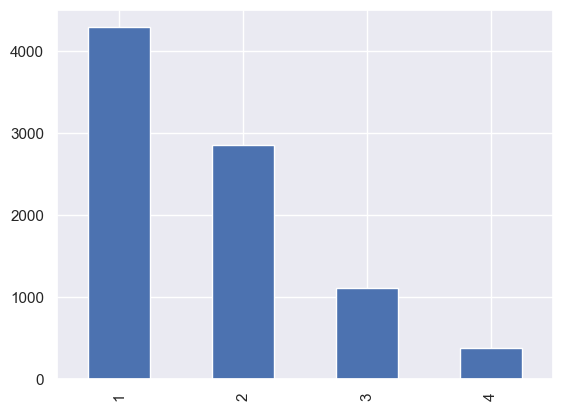

In [18]:
dataframe["Price range"].value_counts().plot(kind="bar")

In [19]:
price_range_transformers = Pipeline(
    [("imputer", SimpleImputer(strategy="most_frequent")), ("scaling", MinMaxScaler())]
)
price_range_transformers

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaling', MinMaxScaler())])

In [20]:
data_pre_processor = ColumnTransformer(
    transformers=[
        ("city_trf", city_transformers, ["City"]),
        ("latlong_trf", lat_long_transformers, ["Longitude", "Latitude"]),
        ("avg_cost_transformers", avg_cost_transformers, ["Average Cost for two"]),
        (
            "yes_no_transformers",
            yes_no_transformers,
            ["Has Table booking", "Has Online delivery"],
        ),
        ("price_range_transformers", price_range_transformers, ["Price range"]),
    ],
    remainder="drop",
)


pre_processed_data = data_pre_processor.fit_transform(dataframe)

print(f"pre processed data shape {pre_processed_data.shape}")

frequent 4 items are ['new delhi', 'gurgaon', 'noida', 'faridabad']
pre processed data shape (8652, 10)


#####  Analyzing Votes

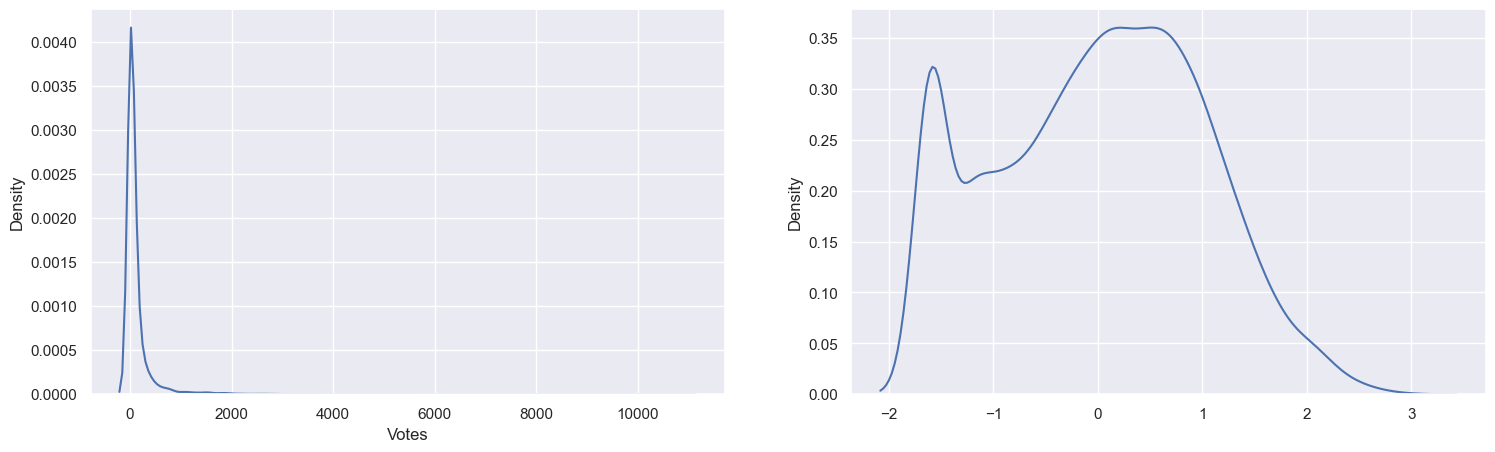

In [21]:
fig, (axs1, axs2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

sns.kdeplot(x="Votes", data=dataframe, ax=axs1)

pt1 = PowerTransformer(method="yeo-johnson", standardize=True)

pt_trf1 = pt1.fit_transform(dataframe[["Votes"]].values)

sns.kdeplot(x=pt_trf1.flatten(), ax=axs2)

plt.show()

In [22]:
data_pre_processor = ColumnTransformer(
    transformers=[
        ("city_trf", city_transformers, ["City"]),
        ("latlong_trf", lat_long_transformers, ["Longitude", "Latitude"]),
        ("avg_cost_transformers", avg_cost_transformers, ["Average Cost for two"]),
        (
            "yes_no_transformers",
            yes_no_transformers,
            ["Has Table booking", "Has Online delivery"],
        ),
        ("price_range_transformers", price_range_transformers, ["Price range"]),
        ("vote_transformers", avg_cost_transformers, ["Votes"]),
    ],
    remainder="drop",
)


pre_processed_data = data_pre_processor.fit_transform(dataframe)

print(f"pre processed data shape {pre_processed_data.shape}")

frequent 4 items are ['new delhi', 'gurgaon', 'noida', 'faridabad']
pre processed data shape (8652, 11)


##### Analyzing Cuisines

In [23]:
dataframe["Cuisines"].describe()

count             8652
unique            1392
top       North Indian
freq               936
Name: Cuisines, dtype: object

In [24]:
dataframe["Cuisines"].isna().sum()

0

In [25]:
cusisine_lst = []
for item in dataframe["Cuisines"].unique().tolist():
    if item is None or item == "":
        continue
    cusisine_lst.extend([*item.split(",")])

cusisine_lst = [str(item).strip().lower() for item in cusisine_lst]
cusisine_lst = list(set(cusisine_lst))
cusisine_lst.sort()

print(f"unique item count {len(cusisine_lst)}")

print(f"unique item List {cusisine_lst}")

unique item count 90
unique item List ['afghani', 'african', 'american', 'andhra', 'arabian', 'armenian', 'asian', 'assamese', 'awadhi', 'bakery', 'bbq', 'belgian', 'bengali', 'beverages', 'bihari', 'biryani', 'british', 'burger', 'burmese', 'cafe', 'cajun', 'charcoal grill', 'chettinad', 'chinese', 'continental', 'cuisine varies', 'deli', 'desserts', 'drinks only', 'european', 'fast food', 'finger food', 'french', 'german', 'goan', 'greek', 'gujarati', 'healthy food', 'hyderabadi', 'ice cream', 'indian', 'indonesian', 'iranian', 'italian', 'japanese', 'juices', 'kashmiri', 'kerala', 'korean', 'lebanese', 'lucknowi', 'maharashtrian', 'malaysian', 'malwani', 'mangalorean', 'mediterranean', 'mexican', 'middle eastern', 'mithai', 'modern indian', 'moroccan', 'mughlai', 'naga', 'nepalese', 'north eastern', 'north indian', 'oriya', 'pakistani', 'parsi', 'persian', 'pizza', 'portuguese', 'rajasthani', 'raw meats', 'salad', 'sandwich', 'seafood', 'south american', 'south indian', 'spanish', '

In [26]:
class Split2MultileColumn(BaseEstimator, TransformerMixin):
    def __init__(self, unique_item_list):
        self.unique_item_list = unique_item_list

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        trnsformed = pd.DataFrame(X, columns=["Column_A"])
        trnsformed["Column_A"] = trnsformed["Column_A"].apply(self.split_items_list)
        return pd.DataFrame(
            trnsformed["Column_A"].to_list(), columns=self.unique_item_list
        )

    def split_items_list(self, items_list):
        c_items = items_list.split(",")
        c_items = [str(item).strip().lower() for item in c_items]
        indexs_lts = [self.unique_item_list.index(item) for item in c_items]

        return_lst = [0] * len(self.unique_item_list)

        for idx in indexs_lts:
            return_lst[idx] = 1
        return return_lst


cusines_transformers = Pipeline(
    [
        ("imputer", SimpleImputer(missing_values="", strategy="constant")),
        (
            "toLower",
            FunctionTransformer(np.vectorize(strip_then_lower_case), validate=False),
        ),
        ("maper", Split2MultileColumn(cusisine_lst)),
    ]
)

cusines_transformers

Pipeline(steps=[('imputer',
                 SimpleImputer(missing_values='', strategy='constant')),
                ('toLower',
                 FunctionTransformer(func=<numpy.vectorize object at 0x0000027FFACD3A00>)),
                ('maper',
                 Split2MultileColumn(unique_item_list=['afghani', 'african',
                                                       'american', 'andhra',
                                                       'arabian', 'armenian',
                                                       'asian', 'assamese',
                                                       'awadhi', 'bakery',
                                                       'bbq', 'belgian',
                                                       'bengali', 'beverages',
                                                       'bihari', 'biryani',
                                                       'british', 'burger',
                                                       'burmese', 'cafe',
                                                       'cajun',
                                                       'charcoal grill',
                                                       'chettinad', 'chinese',
                                                       'continental',
                                                       'cuisine varies', 'deli',
                                                       'desserts',
                                                       'drinks only',
                                                       'european', ...]))])

In [27]:
data_pre_processor = ColumnTransformer(
    transformers=[
        ("city_trf", city_transformers, ["City"]),
        ("latlong_trf", lat_long_transformers, ["Longitude", "Latitude"]),
        ("avg_cost_transformers", avg_cost_transformers, ["Average Cost for two"]),
        (
            "yes_no_transformers",
            yes_no_transformers,
            ["Has Table booking", "Has Online delivery"],
        ),
        ("price_range_transformers", price_range_transformers, ["Price range"]),
        ("vote_transformers", avg_cost_transformers, ["Votes"]),
        ("cusines_transformers", cusines_transformers, ["Cuisines"]),
    ],
    remainder="drop",
)

pre_processed_data = data_pre_processor.fit_transform(dataframe)

print(f"pre processed data shape {pre_processed_data.shape}")

frequent 4 items are ['new delhi', 'gurgaon', 'noida', 'faridabad']
pre processed data shape (8652, 101)


In [28]:
data_pre_processor

ColumnTransformer(transformers=[('city_trf',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(missing_values='new_city',
                                                                strategy='constant')),
                                                 ('toLower',
                                                  FunctionTransformer(func=<numpy.vectorize object at 0x0000027FF66C7880>)),
                                                 ('maper',
                                                  ReduceUnique(unique_count=4)),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                max_categories=5))]),
                                 ['City']),
                                ('latlong_trf',
                                 Pipeline(ste...
                                                  Split2MultileColumn(unique_item_list=['afghani',
                                                                                        'african',
                                                                                        'american',
                                                                                        'andhra',
                                                                                        'arabian',
                                                                                        'armenian',
                                                                                        'asian',
                                                                                        'assamese',
                                                                                        'awadhi',
                                                                                        'bakery',
                                                                                        'bbq',
                                                                                        'belgian',
                                                                                        'bengali',
                                                                                        'beverages',
                                                                                        'bihari',
                                                                                        'biryani',
                                                                                        'british',
                                                                                        'burger',
                                                                                        'burmese',
                                                                                        'cafe',
                                                                                        'cajun',
                                                                                        'charcoal '
                                                                                        'grill',
                                                                                        'chettinad',
                                                                                        'chinese',
                                                                                        'continental',
                                                                                        'cuisine '
                                                                                        'varies',
                                                                                        'deli',
                                                                                        'desserts',
                                                               

### Adding Model GradientBoostingRegressor to Piple Line

In [29]:
model = ensemble.GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.5,
    max_depth=6,
    min_samples_split=21,
    min_samples_leaf=19,
    max_features=0.9,
    loss="squared_error",
)

pipline = Pipeline([("data-processor", data_pre_processor), ("model", model)], verbose=True)

### Test Train Data Spliting

In [30]:
train_df, test_df = train_test_split(dataframe, test_size=0.2)

### Training The Model

In [31]:
pipline.fit(train_df, train_df["Aggregate rating"])

frequent 4 items are ['new delhi', 'gurgaon', 'noida', 'faridabad']
[Pipeline] .... (step 1 of 2) Processing data-processor, total=   0.2s
[Pipeline] ............. (step 2 of 2) Processing model, total=   2.3s


Pipeline(steps=[('data-processor',
                 ColumnTransformer(transformers=[('city_trf',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(missing_values='new_city',
                                                                                 strategy='constant')),
                                                                  ('toLower',
                                                                   FunctionTransformer(func=<numpy.vectorize object at 0x0000027FF66C7880>)),
                                                                  ('maper',
                                                                   ReduceUnique(unique_count=4)),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 max_categories=5))]),
                                                  ['C...
                                                                                                         'beverages',
                                                                                                         'bihari',
                                                                                                         'biryani',
                                                                                                         'british',
                                                                                                         'burger',
                                                                                                         'burmese',
                                                                                                         'cafe',
                                                                                                         'cajun',
                                                                                                         'charcoal '
                                                                                                         'grill',
                                                                                                         'chettinad',
                                                                                                         'chinese',
                                                                                                         'continental',
                                                                                                         'cuisine '
                                                                                                         'varies',
                                                                                                         'deli',
                                                                                                         'desserts',
                                                                                                         'drinks '
                                                                                                         'only',
                                                                                                         'european', ...]))]),
                                                  ['Cuisines'])])),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.5, max_depth=6,
                                           max_features=0.9,
                                           min_samples_leaf=19,
                                           min_samples_split=21))],
         verbose=True)

##### Calculatig Model Score on test data

In [32]:
score = pipline.score(test_df, test_df["Aggregate rating"])
print(f"score {score}")

score 0.9584287947058013


### Saving The Model in Disc

In [33]:
import pickle

model_dir = os.path.join(parent_directory, "model")

model_path = os.path.join(
    model_dir,
    "piplineed_model.pkl",
)

with open(model_path, "wb") as file:
    pickle.dump(pipline, file)

### Loading the Trainind Model and Predicting Target Values

In [34]:
trained_model = None

with open(model_path, "rb") as file:
    trained_model = pickle.load(file)

print(f"Test Data Shape {test_df.shape}")

test_y_predict = trained_model.predict(test_df)

test_df["predicted"] = test_y_predict

print(f"Test predicted output Shape {test_y_predict.shape}")

Test Data Shape (1731, 21)
Test predicted output Shape (1731,)


### Error Disply 

In [35]:
mse = mean_squared_error(test_df["predicted"], test_df["Aggregate rating"])
mae = mean_absolute_error(test_df["predicted"], test_df["Aggregate rating"])

score = r2_score(test_df["Aggregate rating"], test_df["predicted"])

print(f"mean_squared_error {mse}")
print(f"mean_absolute_error {mae}")
print(f"r2_score {score}")

test_df[["predicted", "Aggregate rating"]].head()

mean_squared_error 0.09388853665518401
mean_absolute_error 0.20996102123593832
r2_score 0.9584287947058013


,predicted,Aggregate rating
5266,3.041884,2.8
3777,3.543354,3.5
1075,3.140913,3.0
3026,4.129611,3.9
5063,0.036795,0.0


### Predicted and True Value Distributation

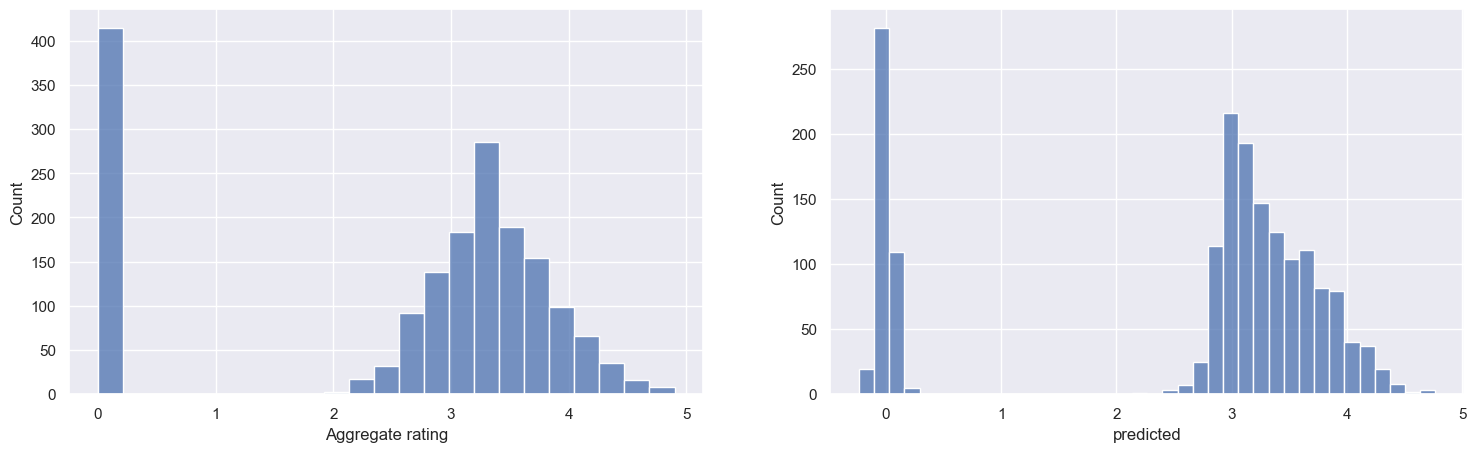

In [36]:
fig, (axs1, axs2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

sns.histplot(x="Aggregate rating", data=test_df, ax=axs1)

sns.histplot(x="predicted", data=test_df, ax=axs2)

plt.show()

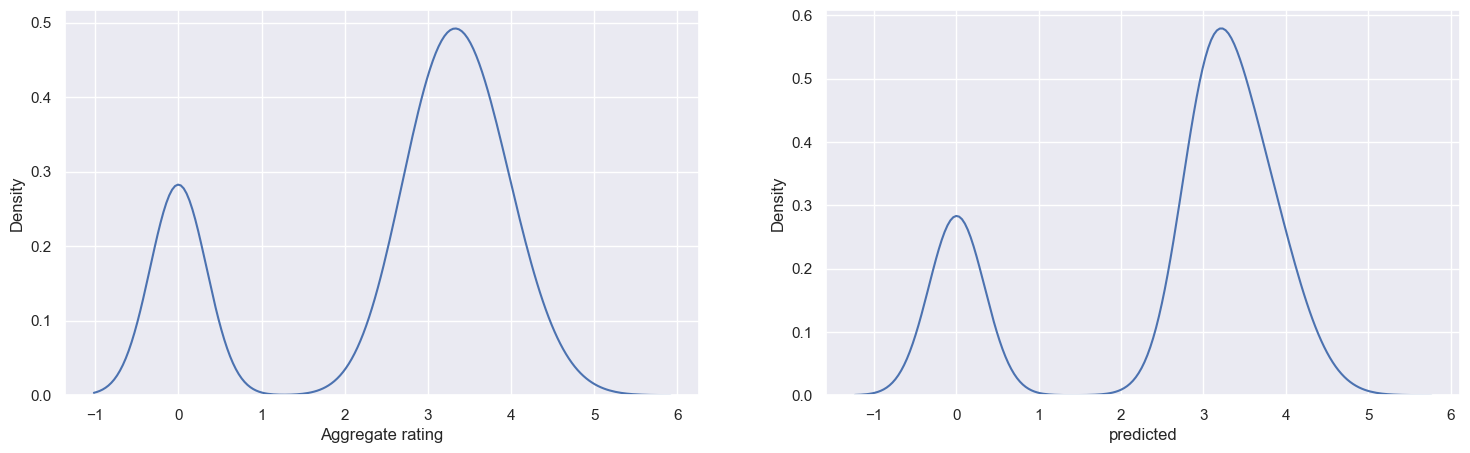

In [37]:
fig, (axs1, axs2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

sns.kdeplot(x="Aggregate rating", data=test_df, ax=axs1)

sns.kdeplot(x="predicted", data=test_df, ax=axs2)

plt.show()

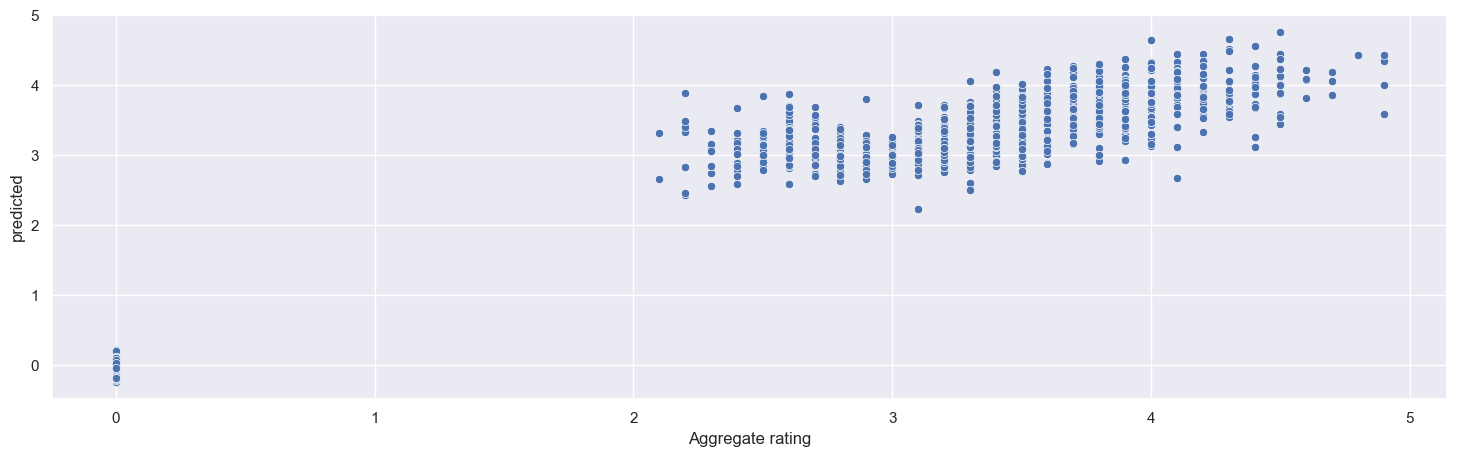

In [38]:
fig, axs1 = plt.subplots(figsize=(18, 5))

sns.scatterplot(x="Aggregate rating", y="predicted", data=test_df, ax=axs1)

plt.show()